In [1]:
!pip install numpy==1.19.2
!pip install tensorflow==2.4.1

import tensorflow.keras
import numpy as np
from tensorflow.keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

from tensorflow.keras.layers import LSTM, RNN, Dropout, Input, LeakyReLU, Bidirectional,Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model
import csv
import matplotlib.pyplot as plt
import nltk
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import random
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

!pip install plot_keras_history
from plot_keras_history import plot_history
import pylab as pl

In [2]:
pip install transformers

In [3]:
from transformers import DistilBertTokenizer, RobertaTokenizer 
import tqdm
distil_bert = 'distilbert-base-uncased' # Pick any desired pre-trained model
ro_bert_a = 'roberta-base'

max_length = 128 #5000
# Defining DistilBERT tokonizer
tokenizer = RobertaTokenizer.from_pretrained(ro_bert_a, do_lower_case=True, add_special_tokens=True,
                                                max_length=max_length, pad_to_max_length=True)

def tokenize(sentences, tokenizer, pad_length=max_length, pad_to_max_length=True ):
    if type(sentences) == str:
        inputs = tokenizer.encode_plus(sentences, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length, 
                                             return_attention_mask=True, return_token_type_ids=True)
        return np.asarray(inputs['input_ids'], dtype='int32'), np.asarray(inputs['attention_mask'], dtype='int32'), np.asarray(inputs['token_type_ids'], dtype='int32')
        
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length, 
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')

In [4]:
inputs = tokenizer.tokenize("The capital of France is [MASK].")
print('INPUTS: ', inputs,'\n')

inputs = tokenizer.tokenize("This is a pretrained model.")
print('INPUTS: ', inputs,'\n')

ids,masks,segments = tokenize("The capital of France is [MASK].", tokenizer)
print('IDS: ', ids)
print('MASKS: ', masks,"\n")
print('SEGMENTS: ', segments)

ids,masks,segments = tokenize("The capital of France is [MASK].", tokenizer, pad_to_max_length=False)
print('IDS: ', ids)
print('MASKS: ',masks)
print('SEGMENTS: ', segments)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


INPUTS:  ['The', 'Ġcapital', 'Ġof', 'ĠFrance', 'Ġis', 'Ġ[', 'MAS', 'K', '].'] 

INPUTS:  ['This', 'Ġis', 'Ġa', 'Ġpret', 'rained', 'Ġmodel', '.'] 

IDS:  [    0   133   812     9  1470    16   646 32804   530  8174     2     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1]
MASKS:  [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [5]:
from google.colab import drive
drive.mount('content')

Drive already mounted at content; to attempt to forcibly remount, call drive.mount("content", force_remount=True).


In [6]:
anxiety_path = '/content/content/MyDrive/Mental_Health_Data/anxiety_pre_features_tfidf_256.csv' 
autism_path = '/content/content/MyDrive/Mental_Health_Data/autism_pre_features_tfidf_256.csv'
bipolar_path = '/content/content/MyDrive/Mental_Health_Data/bipolarreddit_pre_features_tfidf_256.csv'
bpd_path = '/content/content/MyDrive/Mental_Health_Data/bpd_pre_features_tfidf_256.csv'
schizo_path = '/content/content/MyDrive/Mental_Health_Data/schizophrenia_pre_features_tfidf_256.csv'
dep_path = '/content/content/MyDrive/Mental_Health_Data/depression_pre_features_tfidf_256.csv'
mental_path = '/content/content/MyDrive/Mental_Health_Data/mentalhealth_pre_features_tfidf_256.csv'

filepaths = [anxiety_path, autism_path, bipolar_path, bpd_path, schizo_path, dep_path, mental_path]

In [7]:
def loadData(filename):

  rows = []   

  with open(filename, 'r') as csvfile: 
    # creating a csv reader object 
    reader = csv.reader(csvfile, delimiter=',') 
  
    # extracting each data row one by one 
    for row in reader: 
      rows.append([row[0],row[3]])

  return rows[1:len(rows)]

Category, Instances
anxiety 19976
autism 4576
bipolarreddit 2720
bpd 11007
schizophrenia 4281
depression 21209
mentalhealth 18925


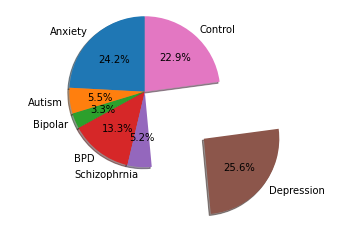

In [8]:
anxiety_data = loadData(anxiety_path)
autism_data = loadData(autism_path)
bipolar_data = loadData(bipolar_path)
bpd_data = loadData(bpd_path)
schizo_data = loadData(schizo_path)
dep_data = loadData(dep_path)
men_data = loadData(mental_path)


print('Category, Instances')
print(anxiety_data[0][0], len(anxiety_data))
print(autism_data[0][0], len(autism_data))
print(bipolar_data[0][0], len(bipolar_data))
print(bpd_data[0][0], len(bpd_data))
print(schizo_data[0][0], len(schizo_data))
print(dep_data[0][0], len(dep_data))
print(men_data[0][0], len(men_data))

names = ['Anxiety', 'Autism', 'Bipolar', 'BPD', 'Schizophrnia', 'Depression', 'Control']
sizes = [len(anxiety_data), len(autism_data), len(bipolar_data), len(bpd_data), len(schizo_data), len(dep_data), len(men_data) ]
explode = (0,0,0,0,0,1,0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=names, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [9]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/content/content/MyDrive/Mental_Health_Data')
import data_augmentation_methods as eda 

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
for i in range(len(anxiety_data)):
  sentence = anxiety_data[0][1]
  label = anxiety_data[0][0]
  augmented_sentences = eda.eda(sentence)
  for j in range(len(augmented_sentences)):
    anxiety_data.append([label, augmented_sentences[j]])

for i in range(len(autism_data)):
  sentence = autism_data[0][1]
  label = autism_data[0][0]
  augmented_sentences = eda.eda(sentence)
  for j in range(len(augmented_sentences)):
    autism_data.append([label, augmented_sentences[j]])

for i in range(len(bipolar_data)):
  sentence = bipolar_data[0][1]
  label = bipolar_data[0][0]
  augmented_sentences = eda.eda(sentence)
  for j in range(len(augmented_sentences)):
    bipolar_data.append([label, augmented_sentences[j]])

for i in range(len(bpd_data)):
  sentence = bpd_data[0][1]
  label = bpd_data[0][0]
  augmented_sentences = eda.eda(sentence)
  for j in range(len(augmented_sentences)):
    bpd_data.append([label, augmented_sentences[j]])

for i in range(len(schizo_data)):
  sentence = schizo_data[0][1]
  label = schizo_data[0][0]
  augmented_sentences = eda.eda(sentence)
  for j in range(len(augmented_sentences)):
    schizo_data.append([label, augmented_sentences[j]])

for i in range(len(dep_data)):
  sentence = dep_data[0][1]
  label = dep_data[0][0]
  augmented_sentences = eda.eda(sentence)
  for j in range(len(augmented_sentences)):
    dep_data.append([label, augmented_sentences[j]])

for i in range(len(men_data)):
  sentence = men_data[0][1]
  label = men_data[0][0]
  augmented_sentences = eda.eda(sentence)
  for j in range(len(augmented_sentences)):
    men_data.append([label, augmented_sentences[j]])

In [11]:
import random

def getRandNumber(min, max, unallowed):
  num = unallowed
  while num == unallowed:
    num = random.randint(min, max)
  return num

arrays = [anxiety_data, autism_data, bipolar_data, bpd_data, schizo_data, dep_data, men_data]

labelled_data = []
target_category = 5

N = len(arrays[target_category])
array = arrays[target_category]
for i in range(N):
    labelled_data.append([array[i],1])

for i in range(N):
    num = getRandNumber(0, len(arrays)-1, target_category)
    array = arrays[num]
    index = random.randint(0, len(array)-1)
    labelled_data.append([array[index],0])

In [12]:
random.shuffle(labelled_data)
print(labelled_data[0][1], labelled_data[5][1], labelled_data[200][1], labelled_data[500][1])

N = len(labelled_data)
print('Length: ', N)

train_percent = 0.6
dev_percent = 0.2
test_percent = 0.2

x_train_data = labelled_data[:int(train_percent*N)]
x_dev_data = labelled_data[int(train_percent*N):int((train_percent+dev_percent)*N)]
x_test_data = labelled_data[int((train_percent+dev_percent)*N):int((train_percent+dev_percent+test_percent)*N)]

assert len(x_dev_data) == len(x_test_data) or len(x_test_data) + 1 or len(x_test_data) -1
assert len(x_dev_data) + len(x_test_data) + len(x_train_data) == N

1 1 1 1
Length:  169672


In [13]:
x_train_int = []
x_train_mask = []
x_train_labels = []

x_dev_int = []
x_dev_mask = []
x_dev_labels = []

x_test_int = []
x_test_mask = []
x_test_labels = []

for i in (range(len(x_train_data))):
  data = x_train_data[i]
  sentence = data[0][1]
  x_train_labels.append(data[1])
  ids,masks,segments = tokenize(sentence, tokenizer, pad_to_max_length=True)
  x_train_int.append(ids)
  x_train_mask.append(masks)

for i in (range(len(x_dev_data))):
  data = x_dev_data[i]
  sentence = data[0][1]
  x_dev_labels.append(data[1])
  ids,masks,segments = tokenize(sentence, tokenizer, pad_to_max_length=True)
  x_dev_int.append(ids)
  x_dev_mask.append(masks)

for i in (range(len(x_test_data))):
  data = x_test_data[i]
  sentence = data[0][1]
  x_test_labels.append(data[1])
  ids,masks,segments = tokenize(sentence, tokenizer, pad_to_max_length=True)
  x_test_int.append(ids)
  x_test_mask.append(masks)  

# If use the previous tokenize function, you can get a print result like:
assert len(x_train_int) == len(x_train_data)
assert len(x_train_mask) == len(x_train_data)

assert len(x_dev_int) == len(x_dev_data)
assert len(x_dev_mask) == len(x_dev_data)

assert len(x_test_int) == len(x_test_data)
assert len(x_test_mask) == len(x_test_data)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [14]:
print("x_dev_int[0]:")
print(x_dev_int[0])
print("x_dev_mask[0]:")
print(x_dev_mask[0])



x_dev_int[0]:
[    0   118   236     7  2254  4158    19    82    53   939 17672   939
    95 33976  2254    97  9379   118  2902 12467 21183  2379   358  1607
  2653   101    10  6976     7   162     5  1690 26749   631    16   939
  2694  5489  7223   236     7    28   441     7  8366   676  4158    19
    82    53   939 17672   358   183   939 32592    53    63    98 29583
     8   939   393   619   143  2789    50    55  2677   225  3804   939
  4443    47   115   194    11   127  1291    19 14051  4356  1686     7
   939   619   101    10  2125     9 15328   142   190   600   939   236
     7   101   592  3258   939    95 17672     8    14  5745   939   283
   160    25   182 13258   939   283   160    25  9888   939   283   160
    25    41 30603    50    41  8446    53     2]
x_dev_mask[0]:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [15]:
def int2onehot(dataset):
  y = []
  for example in dataset:
    if example:
      y.append(np.array([0,1]))
    else:
      y.append(np.array([1,0]))
  return np.array(y)


x_train_labels = np.array(x_train_labels)
x_dev_labels = np.array(x_dev_labels)
x_test_labels = np.array(x_test_labels)
y_train_onehot = int2onehot(x_train_labels)
y_dev_onehot = int2onehot(x_dev_labels)
y_test_onehot = int2onehot(x_test_labels)

print(len(y_train_onehot), len(y_dev_onehot), len(y_test_onehot))

101803 33934 33935


In [16]:
x_train_int_np = np.array(x_train_int)
x_train_mask_np = np.array(x_train_mask)
x_dev_int_np = np.array(x_dev_int)
x_dev_mask_np = np.array(x_dev_mask)
x_test_int_np = np.array(x_test_int)
x_test_mask_np = np.array(x_test_mask)

In [17]:
from transformers import RobertaConfig, TFRobertaForSequenceClassification
import tensorflow as tf

ro_bert_a = 'roberta-base'

config = RobertaConfig(num_labels=2)
config.output_hidden_states = False

def create_RoBERTaForSequenceClassification():
  transformer_model = TFRobertaForSequenceClassification.from_pretrained(ro_bert_a)
  input_ids = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
  input_masks_ids = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')
  X = transformer_model(input_ids, input_masks_ids)
  return tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model on TPU:
  with strategy.scope():
    model = create_RoBERTaForSequenceClassification()
    optimizer = tf.keras.optimizers.Adam(lr=5e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model = create_RoBERTaForSequenceClassification()
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.79.138.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.79.138.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [18]:
model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_for_sequence_classif TFSequenceClassifier 124647170   input_token[0][0]                
                                                                 masked_token[0][0]               
Total params: 124,647,170
Trainable params: 124,647,170
Non-trainable params: 0
__________________________________________________________________________________________________


In [19]:
history = model.fit([x_train_int_np,x_train_mask_np],
                    y_train_onehot,
                    epochs=5,
                    batch_size=512,
                    validation_data=([x_dev_int_np,x_dev_mask_np], y_dev_onehot),
                    verbose=1)

Epoch 1/5


199/199 [==============================] - ETA: 0s - loss: 0.4863 - accuracy: 0.8498WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


199/199 [==============================] - 241s 764ms/step - loss: 0.4850 - accuracy: 0.8501 - val_loss: 0.1026 - val_accuracy: 0.9592
Epoch 2/5
199/199 [==============================] - 81s 405ms/step - loss: 0.1177 - accuracy: 0.9567 - val_loss: 0.1432 - val_accuracy: 0.9630
Epoch 3/5
199/199 [==============================] - 81s 405ms/step - loss: 0.1212 - accuracy: 0.9584 - val_loss: 0.1717 - val_accuracy: 0.8984
Epoch 4/5
199/199 [==============================] - 81s 406ms/step - loss: 0.1609 - accuracy: 0.9324 - val_loss: 0.1067 - val_accuracy: 0.9572
Epoch 5/5
199/199 [==============================] - 81s 405ms/step - loss: 0.1155 - accuracy: 0.9572 - val_loss: 0.1291 - val_accuracy: 0.9594


In [20]:
results = model.evaluate([x_test_int_np,x_test_mask_np], y_test_onehot)
print(results)

1061/1061 [==============================] - 38s 31ms/step - loss: 0.1248 - accuracy: 0.9600
[0.12482868880033493, 0.9599823355674744]


In [21]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

from transformers import TFRobertaForSequenceClassification, TFRobertaModel

def get_BERT_layer():
  ro_bert_a = 'roberta-base'
  config = RobertaConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  return TFRobertaModel.from_pretrained(ro_bert_a)

hdepth=16
MAX_SEQUENCE_LENGTH = 128
EMBED_SIZE=100

def create_bag_of_words_BERT():
  input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32') 

  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]

  pooled_sent=GlobalAveragePooling1DMasked()(embedded_sent)
  hidden_output=Dense(hdepth,input_shape=(MAX_SEQUENCE_LENGTH,EMBED_SIZE),activation='sigmoid',kernel_initializer='glorot_uniform')(pooled_sent) # Sigmoid
  label=Dense(1,input_shape=(hdepth,),activation='sigmoid',kernel_initializer='glorot_uniform')(hidden_output)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model2_BERT')

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model2 = create_bag_of_words_BERT()
    optimizer2 = tf.keras.optimizers.Adam(lr=5e-5)
    model2.compile(optimizer=optimizer2, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model2 = create_bag_of_words_BERT()
  model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.summary() 

INFO:tensorflow:Initializing the TPU system: grpc://10.79.138.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.79.138.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "Model2_BERT"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
global_average_pooling1d_masked (None, 768)          0           tf_roberta_model[0][0] 

In [22]:
history = model2.fit([x_train_int_np,x_train_mask_np],
                    x_train_labels,
                    epochs=5,
                    batch_size=512,
                    validation_data=([x_dev_int_np,x_dev_mask_np], x_dev_labels),
                    verbose=1)

Epoch 1/5


199/199 [==============================] - ETA: 0s - loss: 0.2434 - accuracy: 0.9201WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


199/199 [==============================] - 238s 757ms/step - loss: 0.2431 - accuracy: 0.9202 - val_loss: 0.1551 - val_accuracy: 0.9630
Epoch 2/5
199/199 [==============================] - 80s 404ms/step - loss: 0.1460 - accuracy: 0.9689 - val_loss: 0.1487 - val_accuracy: 0.9652
Epoch 3/5
199/199 [==============================] - 81s 405ms/step - loss: 0.1290 - accuracy: 0.9761 - val_loss: 0.1493 - val_accuracy: 0.9641
Epoch 4/5
199/199 [==============================] - 81s 405ms/step - loss: 0.1126 - accuracy: 0.9828 - val_loss: 0.1494 - val_accuracy: 0.9638
Epoch 5/5
199/199 [==============================] - 81s 405ms/step - loss: 0.1016 - accuracy: 0.9869 - val_loss: 0.1459 - val_accuracy: 0.9639


In [23]:
results = model2.evaluate([x_test_int_np,x_test_mask_np], x_test_labels)
print(results)

1061/1061 [==============================] - 37s 31ms/step - loss: 0.1451 - accuracy: 0.9643
[0.14505493640899658, 0.9642552137374878]


In [24]:
# your code goes here

def get_BERT_layer():
  ro_bert_a = 'roberta-base'
  config = RobertaConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  return TFRobertaModel.from_pretrained(ro_bert_a)
  
def create_CNN_BERT():
  input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32') 

  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]
  conv_vent = Conv1D(kernel_size=3, filters = 800)(embedded_sent)

  pooled_sent=GlobalAveragePooling1DMasked()(conv_vent)
  hidden_output=Dense(hdepth,input_shape=(MAX_SEQUENCE_LENGTH,EMBED_SIZE),activation='sigmoid',kernel_initializer='glorot_uniform')(pooled_sent) # Sigmoid
  label=Dense(1,input_shape=(hdepth,),activation='sigmoid',kernel_initializer='glorot_uniform')(hidden_output)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model2_BERT')

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model3 = create_CNN_BERT()
    optimizer3 = tf.keras.optimizers.Adam(lr=5e-5)
    model3.compile(optimizer=optimizer3, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model3 = create_CNN_BERT()
  model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model3.summary() 

INFO:tensorflow:Initializing the TPU system: grpc://10.79.138.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.79.138.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "Model2_BERT"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model_1 (TFRobertaMo TFBaseModelOutputWit 124645632   input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 126, 800)     1844000     tf_roberta_model_1[0][0

In [25]:
history = model3.fit([x_train_int_np,x_train_mask_np],
                    x_train_labels,
                    epochs=5,
                    batch_size=512,
                    validation_data=([x_dev_int_np,x_dev_mask_np], x_dev_labels),
                    verbose=1)

Epoch 1/5


199/199 [==============================] - ETA: 0s - loss: 0.2443 - accuracy: 0.9244WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


199/199 [==============================] - 242s 772ms/step - loss: 0.2440 - accuracy: 0.9245 - val_loss: 0.1657 - val_accuracy: 0.9650
Epoch 2/5
199/199 [==============================] - 82s 411ms/step - loss: 0.1566 - accuracy: 0.9690 - val_loss: 0.1601 - val_accuracy: 0.9653
Epoch 3/5
199/199 [==============================] - 82s 412ms/step - loss: 0.1389 - accuracy: 0.9761 - val_loss: 0.1543 - val_accuracy: 0.9659
Epoch 4/5
199/199 [==============================] - 82s 411ms/step - loss: 0.1214 - accuracy: 0.9829 - val_loss: 0.1512 - val_accuracy: 0.9663
Epoch 5/5
199/199 [==============================] - 82s 411ms/step - loss: 0.1090 - accuracy: 0.9864 - val_loss: 0.1521 - val_accuracy: 0.9655


In [26]:
results = model3.evaluate([x_test_int_np,x_test_mask_np], x_test_labels)
print(results)

1061/1061 [==============================] - 38s 31ms/step - loss: 0.1507 - accuracy: 0.9656
[0.15074880421161652, 0.9655812978744507]


In [27]:
# your code goes here

def get_BERT_layer():
  ro_bert_a = 'roberta-base'
  config = RobertaConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  return TFRobertaModel.from_pretrained(ro_bert_a)

  
def create_LSTM_BERT():
  input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32') 

  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]
  LSTM_vent = LSTM(units = 50, name='LSTM')(embedded_sent)

  #pooled_sent=GlobalAveragePooling1DMasked()(LSTM_vent)
  hidden_output=Dense(hdepth,input_shape=(MAX_SEQUENCE_LENGTH,EMBED_SIZE),activation='sigmoid',kernel_initializer='glorot_uniform')(LSTM_vent) # Sigmoid
  label=Dense(1,input_shape=(hdepth,),activation='sigmoid',kernel_initializer='glorot_uniform')(hidden_output)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model2_BERT')

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model4 = create_LSTM_BERT()
    optimizer4 = tf.keras.optimizers.Adam(lr=5e-5)
    model4.compile(optimizer=optimizer4, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model4 = create_LSTM_BERT()
  model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model4.summary() 

INFO:tensorflow:Initializing the TPU system: grpc://10.79.138.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.79.138.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "Model2_BERT"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model_2 (TFRobertaMo TFBaseModelOutputWit 124645632   input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
LSTM (LSTM)                     (None, 50)           163800      tf_roberta_model_2[0][0

In [28]:
history = model4.fit([x_train_int_np,x_train_mask_np],
                    x_train_labels,
                    epochs=5,
                    batch_size=512,
                    validation_data=([x_dev_int_np,x_dev_mask_np], x_dev_labels),
                    verbose=1)

Epoch 1/5


199/199 [==============================] - ETA: 0s - loss: 0.3830 - accuracy: 0.8744WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


199/199 [==============================] - 253s 825ms/step - loss: 0.3826 - accuracy: 0.8747 - val_loss: 0.2533 - val_accuracy: 0.9623
Epoch 2/5
199/199 [==============================] - 93s 470ms/step - loss: 0.2414 - accuracy: 0.9640 - val_loss: 0.2270 - val_accuracy: 0.9630
Epoch 3/5
199/199 [==============================] - 93s 469ms/step - loss: 0.2088 - accuracy: 0.9694 - val_loss: 0.2080 - val_accuracy: 0.9633
Epoch 4/5
199/199 [==============================] - 93s 469ms/step - loss: 0.1898 - accuracy: 0.9701 - val_loss: 0.1966 - val_accuracy: 0.9583
Epoch 5/5
199/199 [==============================] - 93s 469ms/step - loss: 0.1676 - accuracy: 0.9753 - val_loss: 0.1835 - val_accuracy: 0.9654


In [29]:
results = model4.evaluate([x_test_int_np,x_test_mask_np], x_test_labels)
print(results)

1061/1061 [==============================] - 39s 32ms/step - loss: 0.1840 - accuracy: 0.9646
[0.18404945731163025, 0.9645793437957764]
